### Import Libraries

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import PolynomialDecay

from datasets import load_dataset
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer, DataCollatorWithPadding

### Load Data

In [3]:
# Load a subset of the 'amazon_polarity'
amazon_train = load_dataset('amazon_polarity', split='train[:20000]')
amazon_test = load_dataset('amazon_polarity', split='test[:2000]')

print("Train Dataset : ", amazon_train.shape)
print("Test Dataset : ", amazon_test.shape)

Found cached dataset amazon_polarity (/Users/jacob/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc)
Found cached dataset amazon_polarity (/Users/jacob/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc)


Train Dataset :  (20000, 3)
Test Dataset :  (2000, 3)


### Exploratory Data Analysis

In [4]:
amazon_train

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 20000
})

In [5]:
amazon_test

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 2000
})

In [6]:
# Preview a review from the the dataset
print(amazon_train[0])

{'label': 1, 'title': 'Stuning even for the non-gamer', 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'}


In [7]:
amazon_train['content']

['This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 "I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 'This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (which means all th

In [8]:
# Define preprocessing variables
vocab_size = 25500
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_token = ''
embedding_dim = 25

In [9]:
df = pd.DataFrame({'Text': amazon_train['content'], 'Label': amazon_train['label']})
df.head()

,Text,Label
0,This sound track was beautiful! It paints the ...,1
1,I'm reading a lot of reviews saying that this ...,1
2,This soundtrack is my favorite music of all ti...,1
3,I truly like this soundtrack and I enjoy video...,1
4,"If you've played the game, you know how divine...",1


In [10]:
df.loc[df['Label'] == 0]

,Text,Label
6,"This is a self-published book, and if you want...",0
10,A complete waste of time. Typographical errors...,0
13,I guess you have to be a romance novel lover f...,0
14,I feel I have to write to keep others from was...,0
15,It's glaringly obvious that all of the glowing...,0
...,...,...
19995,I have previously bought three other books in ...,0
19996,"If you are like me, and thought the anthologie...",0
19997,I love the 1632 series. I have bought every bo...,0
19998,I have to say that after becoming immersed in ...,0


In [11]:
# Define preprocessing function
def preprocess_text(text):
    # Normalize and remove special character
    text = text.lower()
    text = re.sub('[^0-9a-zA-Z]', ' ', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words back into a sentence
    text = ' '.join(words)
    return text

df['Text'] = df['Text'].apply(preprocess_text)

In [12]:
df['Text'][0]

'sound track beautiful paint senery mind well would recomend even people hate vid game music played game chrono cross game ever played best music back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen'

### Data Visualization

In [13]:
# Extract text and labels 
texts = df['Text'].tolist()
labels = df['Label'].tolist()

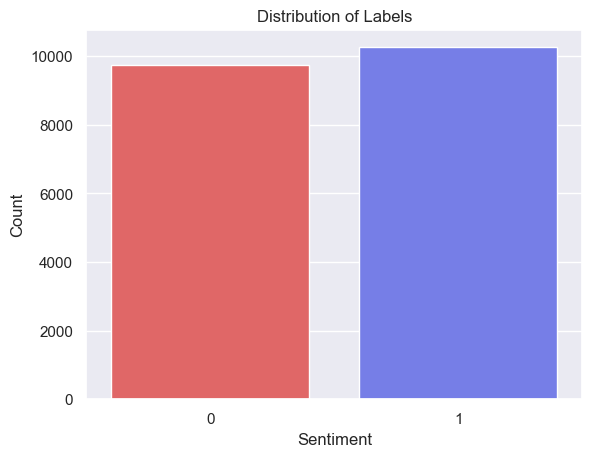

In [14]:
# Display distribution of labels
sns.set(style="darkgrid")
palette = {1: '#636efa', 0: '#f45353'}  # Define colors for each sentiment

sns.countplot(data=df, x='Label', palette=palette)
plt.title('Distribution of Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [15]:
# Display example reviews
print("Example Negative Review:")
print(df[df['Label'] == 0]['Text'].iloc[57])
print("\nExample Positive Review:")
print(df[df['Label'] == 1]['Text'].iloc[23])

Example Negative Review:
yet another example superb book done serious disservice e book publisher multiple spelling error improperly placed figure caption whole section book written cap reason looking excellent reference traditional timber framing look please pick print version instead e book

Example Positive Review:
book worth keep collection advise sourdough ruth also told picture past 100 year ago alaska stand mixer civilized stuff kitchen pot sourdough


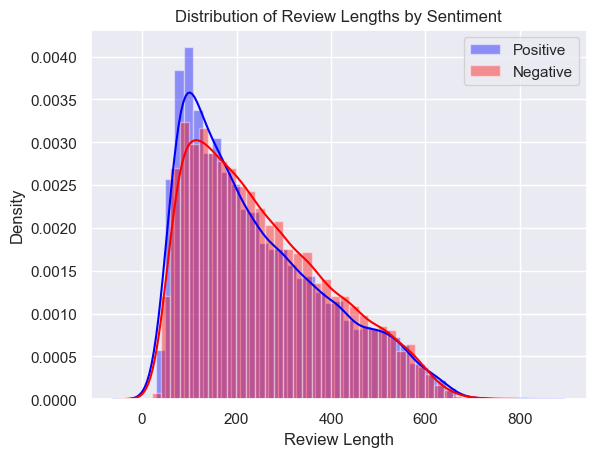

In [16]:
# Calculate the lengths of the reviews
positive_lengths = [len(text) for text, label in zip(texts, labels) if label == 1]
negative_lengths = [len(text) for text, label in zip(texts, labels) if label == 0]

# Create distplot
sns.distplot(positive_lengths, label='Positive', color='blue')
sns.distplot(negative_lengths, label='Negative',color='red')

plt.xlabel('Review Length')
plt.ylabel('Density')
plt.title('Distribution of Review Lengths by Sentiment')
plt.legend()

plt.show()

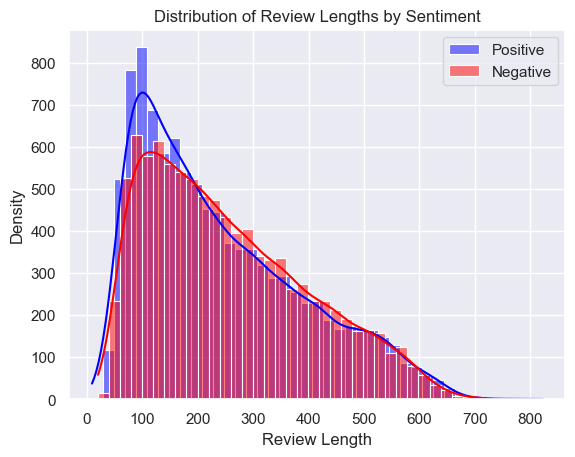

In [17]:
# Calculate the lengths of the reviews
positive_lengths = [len(text) for text, label in zip(texts, labels) if label == 1]
negative_lengths = [len(text) for text, label in zip(texts, labels) if label == 0]

# Create distplot
sns.histplot(positive_lengths, label='Positive', color='blue', kde=True)
sns.histplot(negative_lengths, label='Negative',color='red', kde=True)

plt.xlabel('Review Length')
plt.ylabel('Density')
plt.title('Distribution of Review Lengths by Sentiment')
plt.legend()

plt.show()

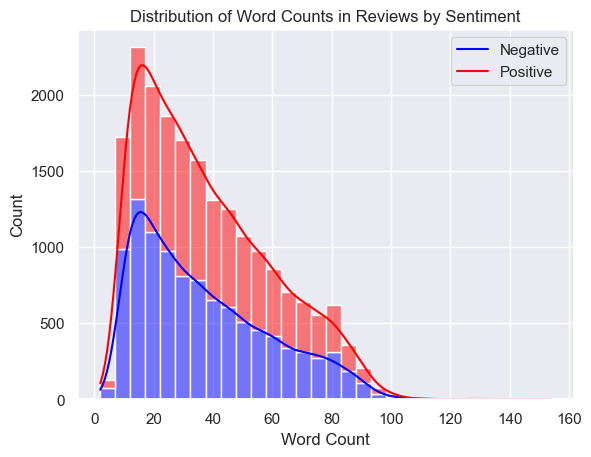

In [18]:
# Explore word count distribution in reviews
df['Word Count'] = df['Text'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x='Word Count', hue='Label', bins=30, multiple='stack', kde=True, palette={0: 'red', 1: 'blue'})
plt.title('Distribution of Word Counts in Reviews by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.legend(['Negative', 'Positive'])
plt.show()

In [19]:
df.head()

,Text,Label,Word Count
0,sound track beautiful paint senery mind well w...,1,40
1,reading lot review saying best game soundtrack...,1,42
2,soundtrack favorite music time hand intense sa...,1,68
3,truly like soundtrack enjoy video game music p...,1,73
4,played game know divine music every single son...,1,41


### Sentiement Analysis using GloVe + LSTM

In [20]:
# Preprocess data
training_sentences = [preprocess_text(sentence) for sentence in amazon_train['content']]
testing_sentences = [preprocess_text(sentence) for sentence in amazon_test['content']]

# Initialize tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(training_sentences)
test_sequences = tokenizer.texts_to_sequences(testing_sentences)

# Pad Sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Get labels
train_labels = amazon_train['label']
test_labels = amazon_test['label']
# Convert to arrays
train_padded, test_padded = np.array(train_padded), np.array(test_padded)
train_labels, test_labels = np.array(train_labels), np.array(test_labels)

In [21]:
# Load GloVe embeddings
embeddings_index = dict()
f = open('../models/glove/glove.twitter.27B.25d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        

### Model Experimentation

#### Create LSTM model

In [22]:
# Initialize model 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
        weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
            metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_padded,
    train_labels,
    validation_data=(test_padded, test_labels),
    epochs=10
)

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-09-26 23:24:20.141988: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-26 23:24:20.142108: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-09-26 23:24:20.504037: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-26 23:24:21.332202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:24:21.531961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:24:21.547307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:24:22.069121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:24:22.091048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 0.6203 - accuracy: 0.6528

2023-09-26 23:24:56.846370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:24:56.938868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:24:56.950725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 39s 59ms/step - loss: 0.6203 - accuracy: 0.6528 - val_loss: 0.5904 - val_accuracy: 0.6850
Epoch 2/10
625/625 [==============================] - 36s 57ms/step - loss: 0.5696 - accuracy: 0.7099 - val_loss: 0.5781 - val_accuracy: 0.6920
Epoch 3/10
625/625 [==============================] - 36s 57ms/step - loss: 0.5554 - accuracy: 0.7183 - val_loss: 0.5775 - val_accuracy: 0.7005
Epoch 4/10
625/625 [==============================] - 36s 58ms/step - loss: 0.5434 - accuracy: 0.7250 - val_loss: 0.5537 - val_accuracy: 0.7135
Epoch 5/10
625/625 [==============================] - 36s 58ms/step - loss: 0.5296 - accuracy: 0.7354 - val_loss: 0.5470 - val_accuracy: 0.7210
Epoch 6/10
625/625 [==============================] - 36s 57ms/step - loss: 0.5197 - accuracy: 0.7418 - val_loss: 0.5315 - val_accuracy: 0.7300
Epoch 7/10
625/625 [==============================] - 36s 57ms/step - loss: 0.5081 - accuracy: 0.7498 - val_loss: 0.5215 - val_accuracy: 0.7360
Epo

In [23]:
# Create function to plot loss/accuracy curves
def plot_graphs(history, string):
	plt.figure(figsize=(5,4))
	plt.plot(history.history[string])
	plt.plot(history.history['val_' + string])
	plt.xlabel("Epochcs")
	plt.ylabel(string)
	plt.legend([string, 'val_' + string])
	plt.show()

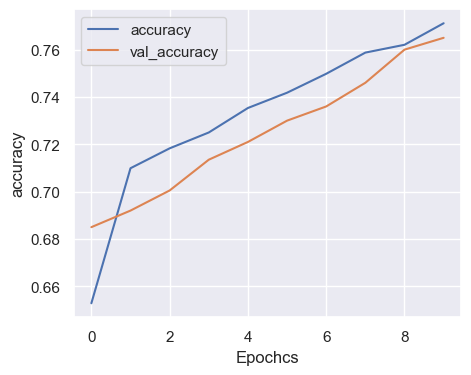

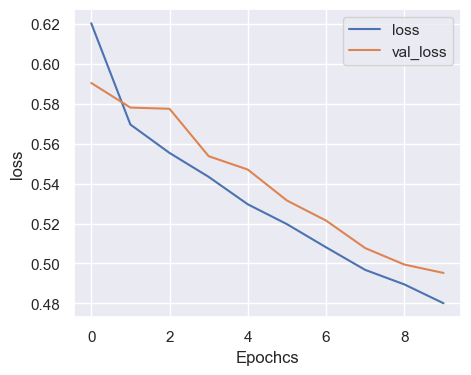

In [24]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [25]:
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
test_loss, test_accuracy

63/63 [==============================] - 2s 33ms/step - loss: 0.4952 - accuracy: 0.7650


(0.4952484369277954, 0.7649999856948853)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
        weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
            metrics=['accuracy']
)

history = model.fit(
    train_padded,
    train_labels,
    validation_data=(test_padded, test_labels),
    epochs=10
)

Epoch 1/10


2023-09-26 23:30:26.611442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:30:26.949006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:30:26.963580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:30:27.312634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:30:27.327553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:30:27.778991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:30:27.801944: I tensorflow/core/grappler/optimizers/cust

625/625 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.6728

2023-09-26 23:31:35.796177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:31:35.945408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:31:35.957055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:31:36.317248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:31:36.329416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 76s 115ms/step - loss: 0.6061 - accuracy: 0.6728 - val_loss: 0.5908 - val_accuracy: 0.6860
Epoch 2/10
625/625 [==============================] - 71s 114ms/step - loss: 0.5615 - accuracy: 0.7139 - val_loss: 0.5652 - val_accuracy: 0.6975
Epoch 3/10
625/625 [==============================] - 70s 111ms/step - loss: 0.5409 - accuracy: 0.7278 - val_loss: 0.5515 - val_accuracy: 0.7145
Epoch 4/10
625/625 [==============================] - 70s 111ms/step - loss: 0.5247 - accuracy: 0.7383 - val_loss: 0.5367 - val_accuracy: 0.7275
Epoch 5/10
625/625 [==============================] - 69s 111ms/step - loss: 0.5058 - accuracy: 0.7491 - val_loss: 0.5161 - val_accuracy: 0.7435
Epoch 6/10
625/625 [==============================] - 69s 110ms/step - loss: 0.4903 - accuracy: 0.7625 - val_loss: 0.5448 - val_accuracy: 0.7385
Epoch 7/10
625/625 [==============================] - 70s 112ms/step - loss: 0.4758 - accuracy: 0.7738 - val_loss: 0.5075 - val_accuracy: 0.7

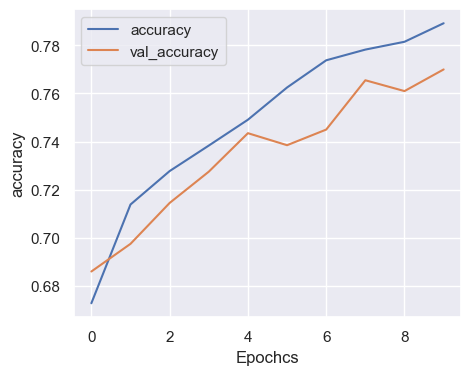

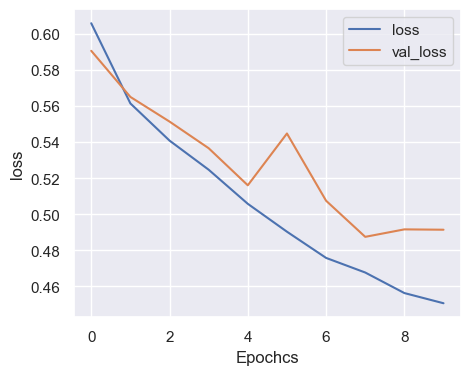

In [27]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [28]:
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
test_loss, test_accuracy

63/63 [==============================] - 4s 62ms/step - loss: 0.4914 - accuracy: 0.7700


(0.49142321944236755, 0.7699999809265137)

#### PolynomialDecay Learning Rate Scheduler

In [29]:
# Define the PolynomialDecay learning rate scheduler
batch_size = 8
num_epochs = 3
num_train_steps = len(train_padded) // batch_size * num_epochs

lr_scheduler = PolynomialDecay(
    initial_learning_rate=1e-8, end_learning_rate=1e-3, decay_steps=num_train_steps
)

# Define the Adam optimizer with the learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
        weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [31]:
# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=optimizer, 
            metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../models/lstm/best_model.h5', monitor='val_loss', save_best_only=True)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)


In [32]:
%reload_ext tensorboard
%tensorboard --logdir=./logs


In [33]:
# Train the model
history = model.fit(
    train_padded,
    train_labels,
    validation_data=(test_padded, test_labels),
    epochs=100,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback])

Epoch 1/100


2023-09-26 23:42:17.634029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:42:17.998136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:42:18.013525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:42:18.362769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:42:18.377841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:42:18.822964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:42:18.845686: I tensorflow/core/grappler/optimizers/cust

625/625 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.6384

2023-09-26 23:43:26.785868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:43:26.935582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:43:26.947216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:43:27.325832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-26 23:43:27.337569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 76s 116ms/step - loss: 0.6357 - accuracy: 0.6384 - val_loss: 0.6141 - val_accuracy: 0.6735
Epoch 2/100
625/625 [==============================] - 70s 112ms/step - loss: 0.5756 - accuracy: 0.7038 - val_loss: 0.5760 - val_accuracy: 0.6985
Epoch 3/100
625/625 [==============================] - 69s 111ms/step - loss: 0.5540 - accuracy: 0.7153 - val_loss: 0.5584 - val_accuracy: 0.7065
Epoch 4/100
625/625 [==============================] - 69s 111ms/step - loss: 0.5281 - accuracy: 0.7375 - val_loss: 0.5437 - val_accuracy: 0.7215
Epoch 5/100
625/625 [==============================] - 69s 111ms/step - loss: 0.4981 - accuracy: 0.7595 - val_loss: 0.5375 - val_accuracy: 0.7225
Epoch 6/100
625/625 [==============================] - 69s 111ms/step - loss: 0.4899 - accuracy: 0.7637 - val_loss: 0.4867 - val_accuracy: 0.7635
Epoch 7/100
625/625 [==============================] - 69s 111ms/step - loss: 0.4746 - accuracy: 0.7719 - val_loss: 0.4830 - val_accurac

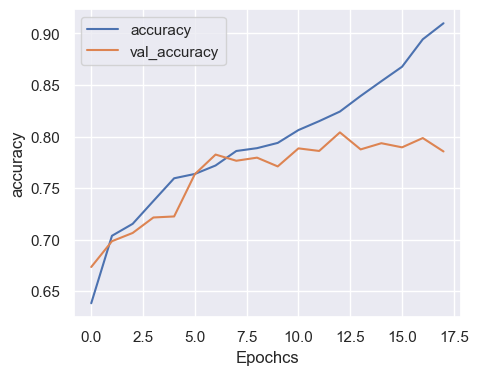

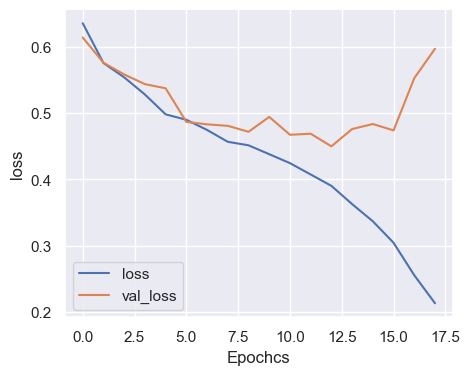

In [34]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Model Evaluation

In [35]:
# Load the best model
best_model = tf.keras.models.load_model('../models/lstm/best_model.h5')

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(test_padded, test_labels)

print(f'Test Accuracy: {test_accuracy*100:.2f}%')


2023-09-27 00:03:15.948762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-27 00:03:16.116211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-27 00:03:16.129469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-27 00:03:16.507022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-27 00:03:16.518931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 6s 74ms/step - loss: 0.4498 - accuracy: 0.8040
Test Accuracy: 80.40%


2023-09-27 00:03:21.932882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-27 00:03:22.057297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-27 00:03:22.069260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-27 00:03:22.444238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-27 00:03:22.456251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 6s 70ms/step


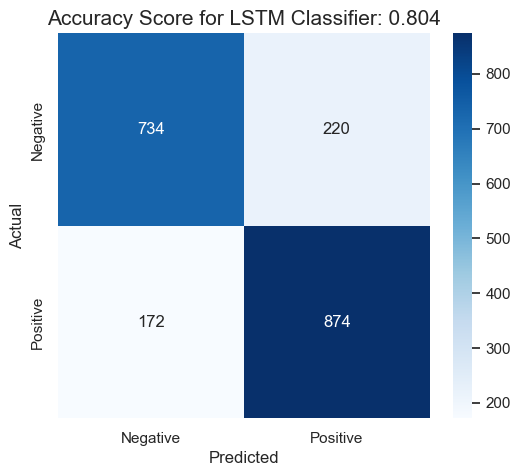

In [36]:
from sklearn.metrics import confusion_matrix

predictions = best_model.predict(test_padded)
predicted_labels = (predictions >= 0.5).astype(int)

# Generate confusion matrix
cf = confusion_matrix(test_labels, predicted_labels)
label_name=["Negative","Positive"]

plt.figure(figsize=(6,5))
sns.heatmap(cf,annot=True,fmt="d",cmap="Blues",xticklabels=label_name,yticklabels=label_name)
all_sample_title = f'Accuracy Score for LSTM Classifier: {test_accuracy:.4}'
plt.title(all_sample_title, size = 15)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

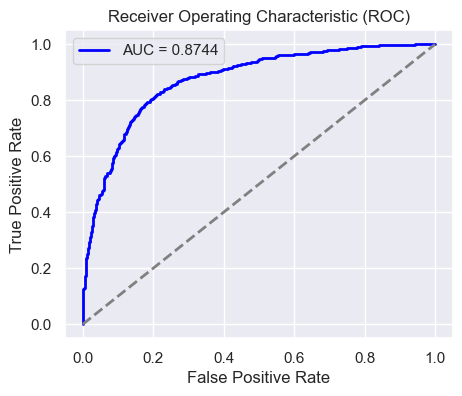

In [45]:
from sklearn.metrics import roc_curve, auc

# Flatten the 2D array into a 1D array
predictions_ravel = predictions.ravel()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predictions_ravel)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = {:.4f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()

### Model Prediction

#### Predicting on original test data

In [38]:
import numpy as np

# Make prediction
predicted_labels = (predictions >= 0.5).astype(int)

# Create lists to store positive and negative sentences
positive_sentences = [amazon_train['content'][i] for i, pred in enumerate(predicted_labels) if pred == 1]
negative_sentences = [amazon_train['content'][i] for i, pred in enumerate(predicted_labels) if pred == 0]

In [39]:
# Print some examples
print("Positive Sentences:")
for i in range(5):  # Print first 5 positive sentences
    print(positive_sentences[i])
    print("\n")

Positive Sentences:
This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^


I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.


This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (whic

In [40]:
# Print some examples
print("Negative Sentences:")
for i in range(5):  # Print first 5 negative sentences
    print(negative_sentences[i])
    print("\n")

Negative Sentences:
I truly like this soundtrack and I enjoy video game music. I have played this game and most of the music on here I enjoy and it's truly relaxing and peaceful.On disk one. my favorites are Scars Of Time, Between Life and Death, Forest Of Illusion, Fortress of Ancient Dragons, Lost Fragment, and Drowned Valley.Disk Two: The Draggons, Galdorb - Home, Chronomantique, Prisoners of Fate, Gale, and my girlfriend likes ZelbessDisk Three: The best of the three. Garden Of God, Chronopolis, Fates, Jellyfish sea, Burning Orphange, Dragon's Prayer, Tower Of Stars, Dragon God, and Radical Dreamers - Unstealable Jewel.Overall, this is a excellent soundtrack and should be brought by those that like video game music.Xander Cross


If you've played the game, you know how divine the music is! Every single song tells a story of the game, it's that good! The greatest songs are without a doubt, Chrono Cross: Time's Scar, Magical Dreamers: The Wind, The Stars, and the Sea and Radical Drea

#### Predicting on sequenced data

In [41]:
predicted_labels = (predictions >= 0.5).astype(int)

# Create lists of positive and negative sentences based on predicted labels 
positive_sentences = [test_padded[i] for i in range(len(predicted_labels)) if predicted_labels[i] == 1]
negative_sentences = [test_padded[i] for i in range(len(predicted_labels)) if predicted_labels[i] == 0]

positive_texts = [tokenizer.sequences_to_texts([sentence])[0] for sentence in positive_sentences]
negative_texts = [tokenizer.sequences_to_texts([sentence])[0] for sentence in negative_sentences]

In [42]:
print("Positive Texts:")
for text in range(5):
    print(positive_texts[text])
    print("\n")


Positive Texts:
lovely pat one great voice generation listened cd year still love good mood make feel better bad mood  like sugar rain cd ooze life vocal   lyric kill one life hidden gem desert isle cd book never made big beyond everytime play matter black white young old male female everybody say one thing singing                                            


despite fact played small portion game music heard plus connection chrono trigger great well led purchase soundtrack remains one favorite album incredible mix fun epic emotional song sad beautiful track especially like many kind song video game soundtrack must admit one song life distant promise brought tear eye many occasion one complaint soundtrack use guitar fretting effect many song find distracting even included would still consider collection worth                                


bought charger  2003 worked ok design nice convenient however year battery would hold charge might well get  disposable look elsewhere charger c

In [43]:
print("Negative Texts:")
for text in range(5):
    print(negative_texts[text])
    print("\n")

Negative Texts:
check  energy website    charger work 100 minute rapid charge option slower charge better battery  mah battery                                                                               


reviewed quite bit combo player hesitant due unfavorable review size machine  vhs collection want replace dvd unit well built easy setup resolution special effect progressive scan hdtv owner suitable many people looking versatile product con universal remote                                                              


also began incorrect disc problem read vcr still work hte dvd side useless understand dvd player sometimes quit even one year sign bad quality giving jvc well sticking sony giving another brand shot                                                                   


scroll dvd menu set vertically triangle key select  select anything dvd besides play special feature language select nothing play                                                                        

#### Predict Sample Text

In [65]:
def predict_sentiment(input_text):
    # Preprocess input text
    inputs = tokenizer.texts_to_sequences([input_text])
    padded = pad_sequences(inputs, maxlen=max_length,
                    padding=padding_type, truncating=trunc_type)

    # Get model prediction
    preiction = model.predict(padded)
    predicted_class = (preiction >= 0.5).astype(int)

    # Determine sentiment label
    sentiment_label = "positive" if predicted_class == 1 else "negative"

    return sentiment_label

1/1 [==============================] - 0s 83ms/step
The sentiment is negative


In [67]:
# Postive test sample
input_text = "I am extremely satisfied with this product. It exceeded my expectations in every way. The quality is top-notch, and it has greatly improved my daily routine. I highly recommend it to others!"
predicted_sentiment = predict_sentiment(input_text)
print(f"The sentiment is {predicted_sentiment}")

1/1 [==============================] - 0s 83ms/step
The sentiment is positive


In [68]:
# Negative test sample
input_text = "Terrible experience. The product was of very low quality and stopped working after just a few days of use. I would not recommend this to anyone"
predicted_sentiment = predict_sentiment(input_text)
print(f"The sentiment is {predicted_sentiment}")

1/1 [==============================] - 0s 78ms/step
The sentiment is negative


### Load Fine-Tuned DisilBERT Model